In [1]:
options(warn=-1)
suppressMessages({library('dplyr')
library('tidyr')
library("reshape2")
library("ggplot2")
library("gridExtra")
library("eulerr")
library("GenomicRanges")})

# Selecting CTCF-bound sites and DHSs devoid of H3K4me3 signal

In [2]:
CTCF_peaks <- read.csv("Auxiliary_data/ENCFF002CEL.bed.gz", header = F, sep = "\t")
CTCF_peaks <- filter(CTCF_peaks, V5 > 250)[,1:3]
CTCF_ranges <- GRanges(seqnames = CTCF_peaks$V1, 
                       ranges=IRanges(start=CTCF_peaks$V2, end=CTCF_peaks$V3))
DHSs <- read.csv("Auxiliary_data/ENCFF621ZJY.bed.gz", header = F, sep = "\t")
DHSs <- filter(DHSs, V7 > 200)[,1:3]
DHS_ranges <- GRanges(seqnames = DHSs$V1, 
                        ranges=IRanges(start=DHSs$V2, end=DHSs$V3))
mask <- read.csv("MChIPC_output/mononucleosomal_and_ChIP/H3K4me3.mask.bed", header = F, sep = "\t")[,c(1:3)]
mask_ranges <- GRanges(seqnames = mask$V1, ranges=IRanges(start=mask$V2-5000, end=mask$V3+5000, enh_id = seq(1,nrow(mask))))

CTCF_wo_H3K4me3 <- CTCF_peaks[-unique(as.data.frame(findOverlaps(CTCF_ranges,mask_ranges))[,1]),]
DHSs_wo_H3K4me3 <- DHSs[-unique(c(as.data.frame(findOverlaps(DHS_ranges,mask_ranges))[,1], as.data.frame(findOverlaps(DHS_ranges,CTCF_ranges))[,1])),]
print(paste0("There is ",nrow(CTCF_wo_H3K4me3), " CTCF-bound sites and ", nrow(DHSs_wo_H3K4me3), " CTCF-less DHSs with no H3K4me3 signal"))
write.table(CTCF_wo_H3K4me3, file="tmp/CTCF_of_interest.bed", col.names = F, row.names = F, sep = "\t", quote = F)
write.table(DHSs_wo_H3K4me3, file="tmp/DHS_of_interest.bed", col.names = F, row.names = F, sep = "\t", quote = F)

[1] "There is 26767 CTCF-bound sites and 21393 CTCF-less DHSs with no H3K4me3 signal"


# Plotting merged MChIP-C, PLAC-seq and Micro-C signals around selected sites

In [3]:
system("computeMatrix reference-point --referencePoint center -S Auxiliary_data/ENCFF352SET.bigWig  Auxiliary_data/ENCFF000BWF.bigWig MChIPC_output/mononucleosomal_and_ChIP/Mononucleosomal_mean.bw MicroC_output/aggregate_profiles/MicroC_merged.ICE.250bp.bw PLACseq_output/aggregate_profiles/PLACseq_merged.250bp.bw MChIPC_output/aggregate_profiles/MChIPC_merged.250bp.bw -R tmp/CTCF_of_interest.bed tmp/DHS_of_interest.bed -p 16 -a 5000 -b 5000 -o tmp/matrix_fig2b -bs 250 --missingDataAsZero", intern=T) 
system("plotHeatmap -m tmp/matrix_fig2b --colorMap OrRd -o Figures/Fig.2/2b_MChIPC_signal_heatmap.pdf --zMax 1 100 10 0.04 40 50 --yMax 1 100 10 0.04 40 50 --yMin 0 --regionsLabel CTCF-bound DHSs --samplesLabel DNase CTCF H3K4me3 Micro-C PLAC-seq MChIP-C", intern=T)
system("computeMatrix reference-point --referencePoint center -S MChIPC_output/aggregate_profiles/MChIPC_merged.250bp.bw PLACseq_output/aggregate_profiles/PLACseq_merged.250bp.bw MicroC_output/aggregate_profiles/MicroC_merged.250bp.bw MicroC_output/aggregate_profiles/MicroC_merged.ICE.250bp.bw HiC_output/aggregate_profiles/HiC_merged.250bp.bw HiC_output/aggregate_profiles/HiC_merged.ICE.250bp.bw -R tmp/CTCF_of_interest.bed tmp/DHS_of_interest.bed -p 16 -a 5000 -b 5000 -o tmp/matrix_figS2b --outFileNameMatrix tmp/matrix_figS2b.txt -bs 250 --missingDataAsZero", intern=T)

character(0)

character(0)

character(0)

# Plotting aggregate promoter-ligation signal for MChIP-C, PLAC-seq, Micro-C and Hi-C around CTCF-bound and CTCF-less DHSs

In [3]:
matrix <- read.csv("tmp/matrix_figS2b.txt", header = F, sep = "\t")
matrix <- matrix[4:nrow(matrix),1:240]
nr <- nrow(matrix)
matrix <- sapply(matrix, as.numeric)
CTCF_n <- nrow(CTCF_wo_H3K4me3)

# extracting and plotting signals around CTCF-bound sites
violin_data_CTCF <- data.frame(MChIPC_5kb=c(unlist(matrix[1:CTCF_n,c(1,40)])),
                          MChIPC_1kb=c(unlist(matrix[1:CTCF_n,c(16,25)])),
                          MChIPC=c(unlist(matrix[1:CTCF_n,c(20:21)])),
                          PLACseq_5kb=c(unlist(matrix[1:CTCF_n,c(41,80)])),
                          PLACseq_1kb=c(unlist(matrix[1:CTCF_n,c(56,75)])),
                          PLACseq=c(unlist(matrix[1:CTCF_n,c(60:61)])),
                          MicroC_5kb=c(unlist(matrix[1:CTCF_n,c(81,120)])),
                          MicroC_1kb=c(unlist(matrix[1:CTCF_n,c(96,105)])),
                          MicroC=c(unlist(matrix[1:CTCF_n,c(100:101)])),
                          MicroC_ICE_5kb=1000*c(unlist(matrix[1:CTCF_n,c(121,160)])),
                          MicroC_ICE_1kb=1000*c(unlist(matrix[1:CTCF_n,c(136,145)])),
                          MicroC_ICE=1000*c(unlist(matrix[1:CTCF_n,c(140:141)])),
                          HiC_5kb=c(unlist(matrix[1:CTCF_n,c(161,200)])),
                          HiC_1kb=c(unlist(matrix[1:CTCF_n,c(176,185)])),
                          HiC=c(unlist(matrix[1:CTCF_n,c(180:181)])),
                          HiC_ICE_5kb=c(unlist(matrix[1:CTCF_n,c(201,240)])),
                          HiC_ICE_1kb=c(unlist(matrix[1:CTCF_n,c(216,225)])),
                          HiC_ICE=c(unlist(matrix[1:CTCF_n,c(220:221)])))

MChIPC_violin <- ggplot(melt(violin_data_CTCF[,1:3])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="Signal in 250bp bin (log2)",x="") + 
     scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
     ggtitle("MChIP-C\n(merged)\n")+ guides(fill=FALSE)

PLACseq_violin <- ggplot(melt(violin_data_CTCF[,4:6])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
     ggtitle("PLAC-seq\n(merged)\n")+ guides(fill=FALSE)

MicroC_violin <- ggplot(melt(violin_data_CTCF[,7:9])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
     ggtitle("Micro-C\n(promoter-\nanchored)")+ guides(fill=FALSE)

MicroC_ICE_violin <- ggplot(melt(violin_data_CTCF[,10:12])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
     ggtitle("Micro-C ICE\n(promoter-\nanchored)")+ guides(fill=FALSE)

HiC_violin <- ggplot(melt(violin_data_CTCF[,13:15])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
     ggtitle("Hi-C\n(promoter-\nanchored)")+ guides(fill=FALSE)

HiC_ICE_violin <- ggplot(melt(violin_data_CTCF[,16:18])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","CTCF")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","lightsteelblue1","royalblue2"))+
     ggtitle("Hi-C ICE\n(promoter-\nanchored)")+ guides(fill=FALSE)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



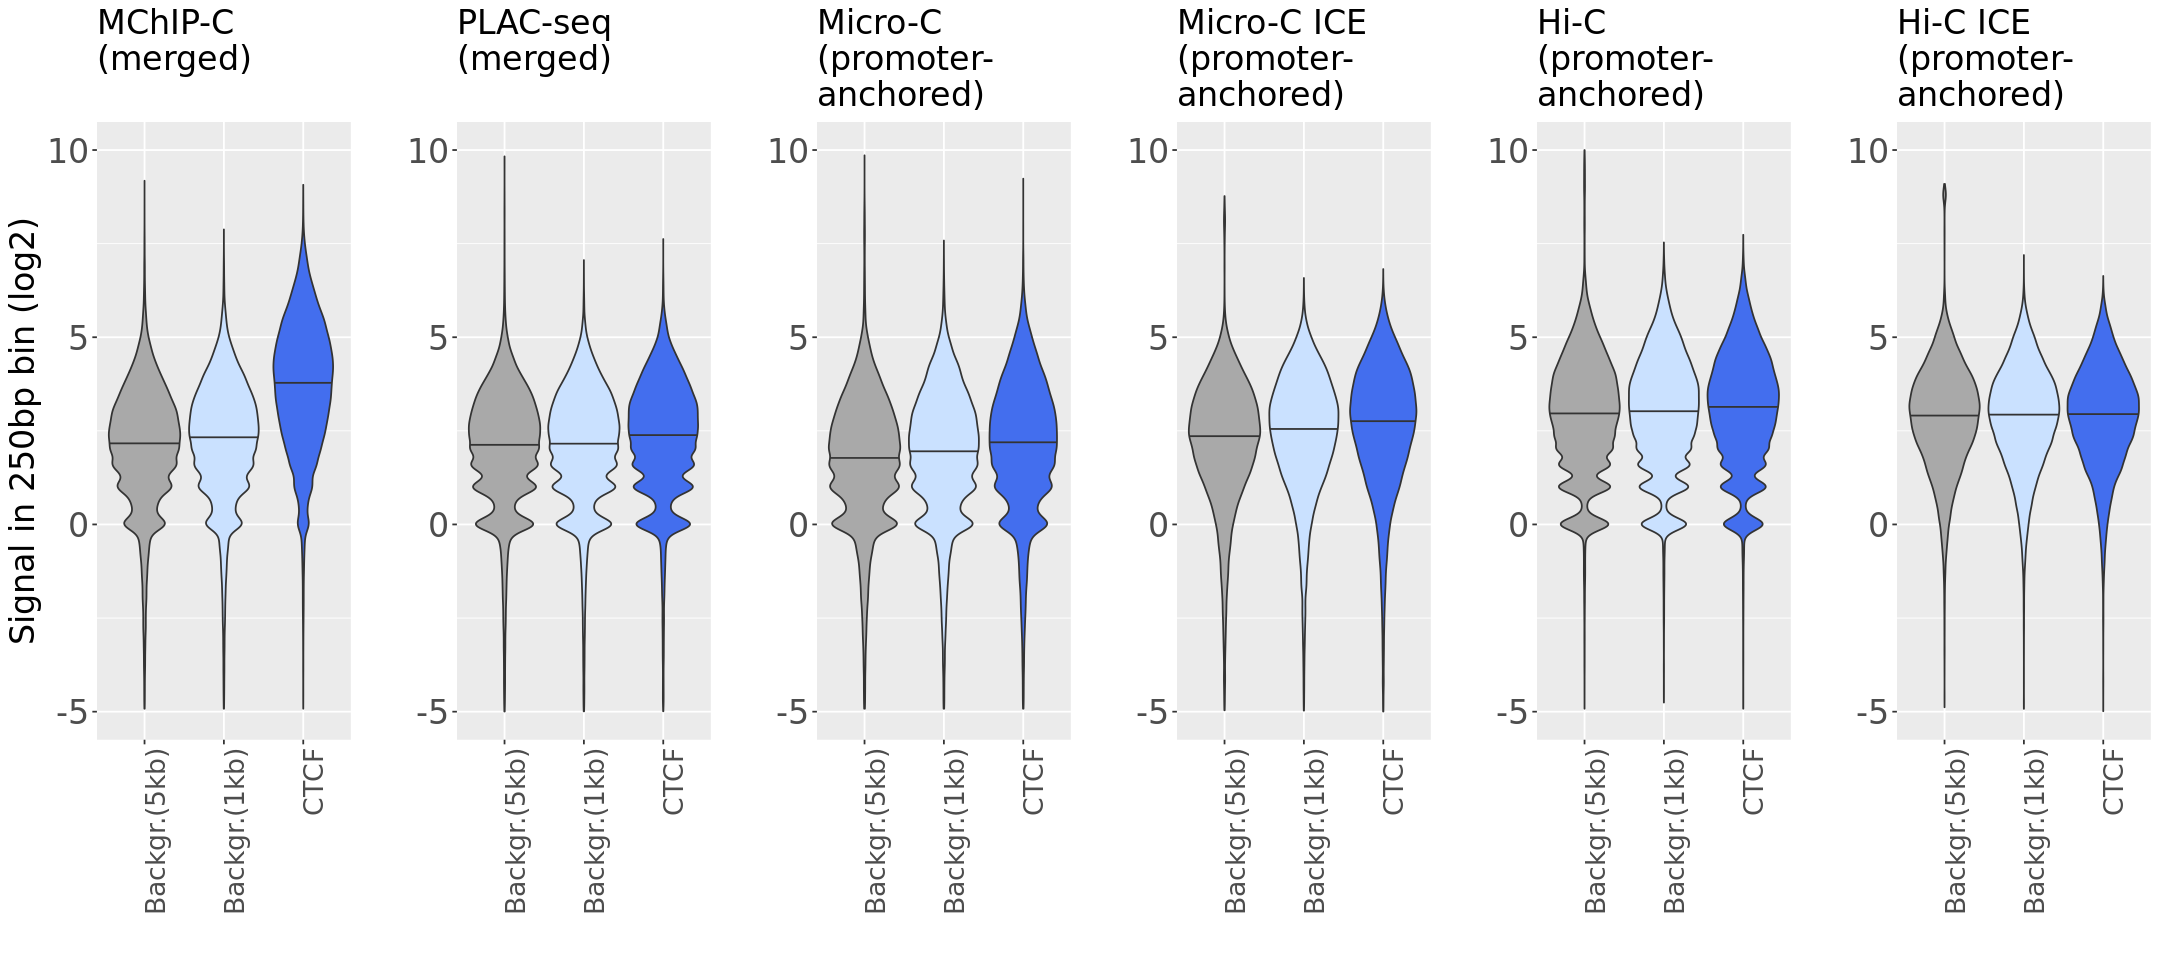

In [4]:
options(repr.plot.width=18, repr.plot.height=8)
grid.arrange(MChIPC_violin, PLACseq_violin, MicroC_violin, MicroC_ICE_violin, HiC_violin, HiC_ICE_violin, ncol=6)

In [5]:
pdf("Figures/Fig.S2/S2b_ligation_signal_CTCFs.pdf", width=18, height=8)
grid.arrange(MChIPC_violin, PLACseq_violin, MicroC_violin, MicroC_ICE_violin, HiC_violin, HiC_ICE_violin, ncol=6)
dev.off()

png 
  2

In [6]:
# extracting and plotting signals around DNase hypersensitive sites
violin_data_CTCF <- data.frame(MChIPC_5kb=c(unlist(matrix[(CTCF_n+1):nr,c(1,40)])),
                          MChIPC_1kb=c(unlist(matrix[(CTCF_n+1):nr,c(16,25)])),
                          MChIPC=c(unlist(matrix[(CTCF_n+1):nr,c(20:21)])),
                          PLACseq_5kb=c(unlist(matrix[(CTCF_n+1):nr,c(41,80)])),
                          PLACseq_1kb=c(unlist(matrix[(CTCF_n+1):nr,c(56,75)])),
                          PLACseq=c(unlist(matrix[(CTCF_n+1):nr,c(60:61)])),
                          MicroC_5kb=c(unlist(matrix[(CTCF_n+1):nr,c(81,120)])),
                          MicroC_1kb=c(unlist(matrix[(CTCF_n+1):nr,c(96,105)])),
                          MicroC=c(unlist(matrix[(CTCF_n+1):nr,c(100:101)])),
                          MicroC_ICE_5kb=1000*c(unlist(matrix[(CTCF_n+1):nr,c(121,160)])),
                          MicroC_ICE_1kb=1000*c(unlist(matrix[(CTCF_n+1):nr,c(136,145)])),
                          MicroC_ICE=1000*c(unlist(matrix[(CTCF_n+1):nr,c(140:141)])),
                          HiC_5kb=c(unlist(matrix[(CTCF_n+1):nr,c(161,200)])),
                          HiC_1kb=c(unlist(matrix[(CTCF_n+1):nr,c(176,185)])),
                          HiC=c(unlist(matrix[(CTCF_n+1):nr,c(180:181)])),
                          HiC_ICE_5kb=c(unlist(matrix[(CTCF_n+1):nr,c(201,240)])),
                          HiC_ICE_1kb=c(unlist(matrix[(CTCF_n+1):nr,c(216,225)])),
                          HiC_ICE=c(unlist(matrix[(CTCF_n+1):nr,c(220:221)])))

MChIPC_violin <- ggplot(melt(violin_data_CTCF[,1:3])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="Signal in 250bp bin (log2)",x="") + 
     scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
     ggtitle("MChIP-C\n(merged)\n")+ guides(fill=FALSE)

PLACseq_violin <- ggplot(melt(violin_data_CTCF[,4:6])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
     ggtitle("PLAC-seq\n(merged)\n")+ guides(fill=FALSE)

MicroC_violin <- ggplot(melt(violin_data_CTCF[,7:9])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
     ggtitle("Micro-C\n(promoter-\nanchored)")+ guides(fill=FALSE)

MicroC_ICE_violin <- ggplot(melt(violin_data_CTCF[,10:12])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
     ggtitle("Micro-C ICE\n(promoter-\nanchored)")+ guides(fill=FALSE)

HiC_violin <- ggplot(melt(violin_data_CTCF[,13:15])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
     ggtitle("Hi-C\n(promoter-\nanchored)")+ guides(fill=FALSE)

HiC_ICE_violin <- ggplot(melt(violin_data_CTCF[,16:18])) + 
geom_violin(aes(variable, log2(value+0.005), fill=variable), draw_quantiles=0.5)+ ylim(-5,10) +
scale_x_discrete(labels=c("Backgr.(5kb)","Backgr.(1kb)","DHS")) + 
theme(axis.text.x = element_text(size = 16, angle=90, hjust=1), axis.text.y = element_text(size = 20),text=element_text(size=20),
     plot.title=element_text(size=20)) + labs(y="",x="") + 
     scale_fill_manual(values=c("darkgrey","tan","darkorange3"))+
     ggtitle("Hi-C ICE\n(promoter-\nanchored)")+ guides(fill=FALSE)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



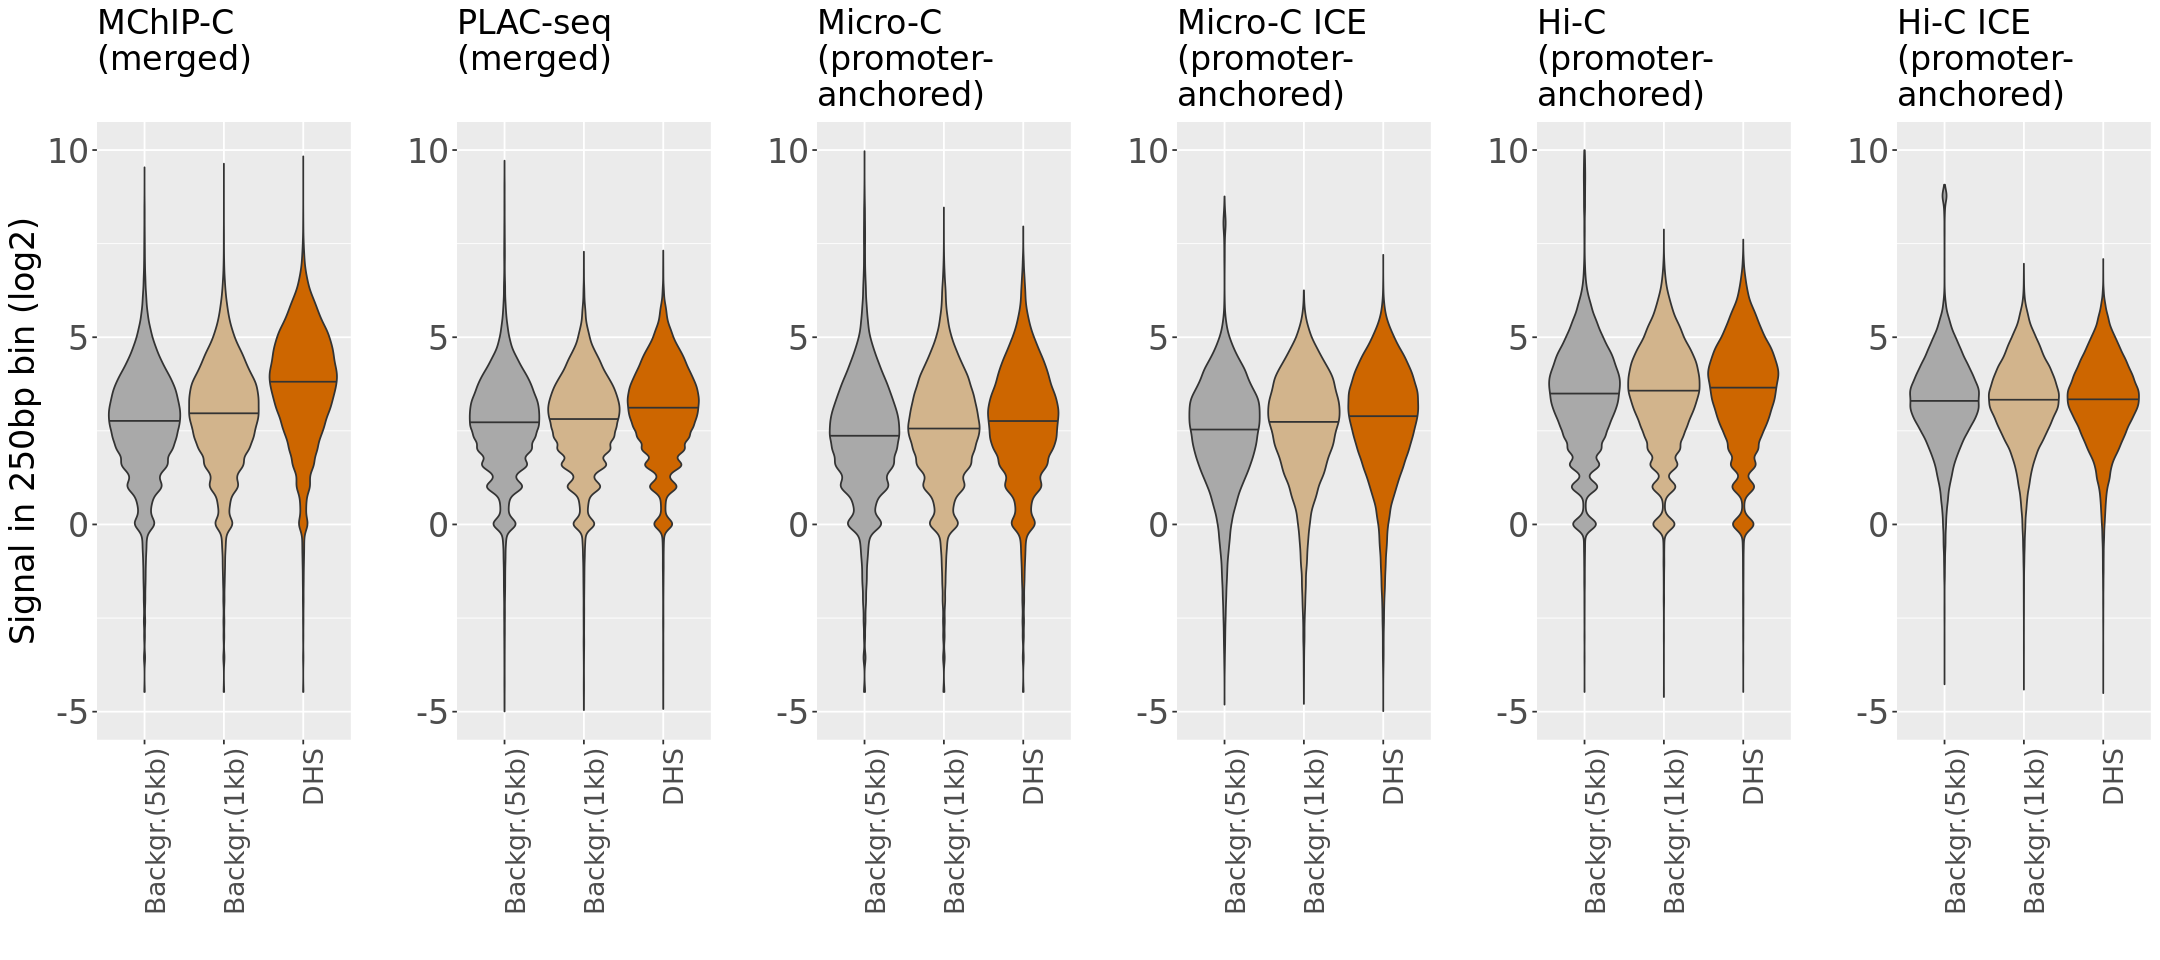

In [7]:
options(repr.plot.width=18, repr.plot.height=8)
grid.arrange(MChIPC_violin, PLACseq_violin, MicroC_violin, MicroC_ICE_violin, HiC_violin, HiC_ICE_violin, ncol=6)

In [8]:
pdf("Figures/Fig.S2/S2b_ligation_signal_DHSs.pdf", width=18, height=8)
grid.arrange(MChIPC_violin, PLACseq_violin, MicroC_violin, MicroC_ICE_violin, HiC_violin, HiC_ICE_violin, ncol=6)
dev.off()

png 
  2

# Additional comparison of MChIP-C, PLAC-seq and Micro-C sensitivity

# Data preparation

In [48]:
rm(list=ls()[!(ls()%in%c("DHSs","CTCF_peaks","DHS_ranges","CTCF_ranges"))])
colnames(CTCF_peaks)<-c("CTCF_chr","CTCF_start","CTCF_end")
DHSs <- DHSs[-(as.data.frame(findOverlaps(DHS_ranges,CTCF_ranges))[,1]),]
DHS_ranges <- GRanges(seqnames = DHSs$V1, ranges=IRanges(start=DHSs$V2, end=DHSs$V3))          
colnames(DHSs)<-c("DHS_chr","DHS_start","DHS_end")
vp <- read.csv("MChIPC_output/MChIPC_viewpoints.bed", header = F, sep = "\t")[,1:4]
vp_ranges <- GRanges(seqnames = vp$V1, ranges=IRanges(start=vp$V2, end=vp$V3))
colnames(vp)<-c("vp_chr","vp_start","vp_end","vp_name")

In [62]:
# prepairing MChIP-C data
MChIPC_int <- read.csv("MChIPC_output/MChIPC_interactions.bedpe", header = F, sep = "\t")
MChIPC_OE_ranges <- GRanges(seqnames = MChIPC_int$V4, ranges=IRanges(start=MChIPC_int$V5, end=MChIPC_int$V6))
MChIPC_int <- MChIPC_int[-(as.data.frame(findOverlaps(MChIPC_OE_ranges,vp_ranges))[,1]),]
MChIPC_OE_ranges <- GRanges(seqnames = MChIPC_int$V4, ranges=IRanges(start=MChIPC_int$V5, end=MChIPC_int$V6))
MChIPC_CTCF <- distinct(cbind(MChIPC_int[as.data.frame(findOverlaps(MChIPC_OE_ranges,CTCF_ranges))[,1],],
                     CTCF_peaks[as.data.frame(findOverlaps(MChIPC_OE_ranges,CTCF_ranges))[,2],]))
MChIPC_DHS <- distinct(cbind(MChIPC_int[as.data.frame(findOverlaps(MChIPC_OE_ranges,DHS_ranges))[,1],],
                     DHSs[as.data.frame(findOverlaps(MChIPC_OE_ranges,DHS_ranges))[,2],]))
colnames(MChIPC_CTCF)[1:6] <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end")
colnames(MChIPC_DHS)[1:6] <- c("vp_chr","vp_start","vp_end","OE_chr","OE_start","OE_end")
MChIPC_CTCF$V4 <- rownames(MChIPC_CTCF)
MChIPC_DHS$V4 <- rownames(MChIPC_DHS)
MChIPC_CTCF <- separate(MChIPC_CTCF, V4, sep = "\\.", into=c("int_index"))
MChIPC_DHS <- separate(MChIPC_DHS, V4, sep = "\\.", into=c("int_index"))
MChIPC_CTCF_dist <- distinct(MChIPC_CTCF[,c(1:3,7:10)])
MChIPC_DHS_dist <- distinct(MChIPC_DHS[,c(1:3,7:10)])
MChIPC_CTCF_dist <- left_join(MChIPC_CTCF_dist, 
                     mutate(distinct(MChIPC_CTCF_dist[,1:6]), pair=1:nrow(distinct(MChIPC_CTCF_dist[,1:6]))))
MChIPC_DHS_dist <- left_join(MChIPC_DHS_dist, 
                     mutate(distinct(MChIPC_DHS_dist[,1:6]), pair=1:nrow(distinct(MChIPC_DHS_dist[,1:6]))))
MChIPC_CTCF_dist$unique <- !(MChIPC_CTCF_dist$int_index %in% 
                              unique(c(MChIPC_CTCF_dist$int_index[duplicated(MChIPC_CTCF_dist$int_index)],
                                       MChIPC_CTCF_dist$int_index[duplicated(MChIPC_CTCF_dist$int_index, 
                                                                              fromLast=T)])))
MChIPC_DHS_dist$unique <- !(MChIPC_DHS_dist$int_index %in% 
                              unique(c(MChIPC_DHS_dist$int_index[duplicated(MChIPC_DHS_dist$int_index)],
                                       MChIPC_DHS_dist$int_index[duplicated(MChIPC_DHS_dist$int_index, 
                                                                              fromLast=T)])))
MChIPC_CTCF <- left_join(MChIPC_CTCF, vp)
MChIPC_DHS <- left_join(MChIPC_DHS, vp)

N1 <- length(unique(MChIPC_CTCF_dist$pair))
N3 <- round(100*length(unique(MChIPC_CTCF_dist$pair[!(MChIPC_CTCF_dist$unique)]))/length(unique(MChIPC_CTCF_dist$pair)),2)
N2 <- length(unique(MChIPC_DHS_dist$pair))
N4 <- round(100*length(unique(MChIPC_DHS_dist$pair[!(MChIPC_DHS_dist$unique)]))/length(unique(MChIPC_DHS_dist$pair)),2)
cat(paste0("We identified ",N1," unique P-CTCF interactions in MChIP-C data and ",N2,
           " unique P-DHS interactions.\n",N3,"% and ",N4,
           "% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type."))
rm(list=c("MChIPC_CTCF_dist","MChIPC_DHS_dist","MChIPC_int","N1","N2","N3","N4"))

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end)`


We identified 29321 unique viewpoint-CTCF interactions in MChIP-C data and 13913 unique viewpoint-DHS interactions.
2.66% and 4.97% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type.

In [61]:
# prepairing PLAC-seq data
PLACseq_int <- read.csv("PLACseq_output//PLACseq_interactions.bedpe", header = F, sep = "\t")
PLACseq_vp_ranges <- GRanges(seqnames = PLACseq_int$V1, ranges=IRanges(start=PLACseq_int$V2, end=PLACseq_int$V3))
PLACseq_int <- cbind(PLACseq_int[as.data.frame(findOverlaps(PLACseq_vp_ranges,vp_ranges))[,1],],
                     vp[as.data.frame(findOverlaps(PLACseq_vp_ranges,vp_ranges))[,2],])
PLACseq_OE_ranges <- GRanges(seqnames = PLACseq_int$V4, ranges=IRanges(start=PLACseq_int$V5, end=PLACseq_int$V6))
PLACseq_int <- PLACseq_int[-(as.data.frame(findOverlaps(PLACseq_OE_ranges,vp_ranges))[,1]),]
rownames(PLACseq_int) <- 1:nrow(PLACseq_int)
PLACseq_OE_ranges <- GRanges(seqnames = PLACseq_int$V4, ranges=IRanges(start=PLACseq_int$V5, end=PLACseq_int$V6))
PLACseq_CTCF <- distinct(cbind(PLACseq_int[as.data.frame(findOverlaps(PLACseq_OE_ranges,CTCF_ranges))[,1],],
                     CTCF_peaks[as.data.frame(findOverlaps(PLACseq_OE_ranges,CTCF_ranges))[,2],]))[,c(7:9,4:6,11:13,10)]
PLACseq_DHS <- distinct(cbind(PLACseq_int[as.data.frame(findOverlaps(PLACseq_OE_ranges,DHS_ranges))[,1],],
                     DHSs[as.data.frame(findOverlaps(PLACseq_OE_ranges,DHS_ranges))[,2],]))[,c(7:9,4:6,11:13,10)]
colnames(PLACseq_CTCF)[4:6] <- c("OE_chr","OE_start","OE_end")
colnames(PLACseq_DHS)[4:6] <- c("OE_chr","OE_start","OE_end")
PLACseq_CTCF$V4 <- rownames(PLACseq_CTCF)
PLACseq_DHS$V4 <- rownames(PLACseq_DHS)
PLACseq_CTCF <- separate(PLACseq_CTCF, V4, sep = "\\.", into=c("int_index"))
PLACseq_DHS <- separate(PLACseq_DHS, V4, sep = "\\.", into=c("int_index"))
PLACseq_CTCF_dist <- distinct(PLACseq_CTCF[,c(1:3,7:9,11)])
PLACseq_DHS_dist <- distinct(PLACseq_DHS[,c(1:3,7:9,11)])
PLACseq_CTCF_dist <- left_join(PLACseq_CTCF_dist, 
                     mutate(distinct(PLACseq_CTCF_dist[,1:6]), pair=1:nrow(distinct(PLACseq_CTCF_dist[,1:6]))))
PLACseq_DHS_dist <- left_join(PLACseq_DHS_dist, 
                     mutate(distinct(PLACseq_DHS_dist[,1:6]), pair=1:nrow(distinct(PLACseq_DHS_dist[,1:6]))))
PLACseq_CTCF_dist$unique <- !(PLACseq_CTCF_dist$int_index %in% 
                    unique(c(PLACseq_CTCF_dist$int_index[duplicated(PLACseq_CTCF_dist$int_index)],
                             PLACseq_CTCF_dist$int_index[duplicated(PLACseq_CTCF_dist$int_index, fromLast=T)])))
PLACseq_DHS_dist$unique <- !(PLACseq_DHS_dist$int_index %in% 
                    unique(c(PLACseq_DHS_dist$int_index[duplicated(PLACseq_DHS_dist$int_index)],
                             PLACseq_DHS_dist$int_index[duplicated(PLACseq_DHS_dist$int_index, fromLast=T)])))

N1 <- length(unique(PLACseq_CTCF_dist$pair))
N3 <- round(100*length(unique(PLACseq_CTCF_dist$pair[!(PLACseq_CTCF_dist$unique)]))/length(unique(PLACseq_CTCF_dist$pair)),2)
N2 <- length(unique(PLACseq_DHS_dist$pair))
N4 <- round(100*length(unique(PLACseq_DHS_dist$pair[!(PLACseq_DHS_dist$unique)]))/length(unique(PLACseq_DHS_dist$pair)),2)
cat(paste0("We identified ",N1," unique P-CTCF interactions in PLAC-seq data and ",N2,
           " unique P-DHS interactions.\n",N3,"% and ",N4,
           "% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type."))
rm(list=c("PLACseq_CTCF_dist","PLACseq_DHS_dist","PLACseq_int","N1","N2","N3","N4"))

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`


We identified 3376 unique viewpoint-CTCF interactions in PLAC-seq data and 3487 unique viewpoint-DHS interactions.
34.45% and 61.92% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type.

In [63]:
# prepairing Micro-C data
MicroC_int <- read.csv("MicroC_output//MicroC_interactions_min.bedpe", header = F, sep = "\t")[,1:6]
MicroC_E1_ranges <- GRanges(seqnames = MicroC_int$V1, ranges=IRanges(start=MicroC_int$V2, end=MicroC_int$V3))
MicroC_E2_ranges <- GRanges(seqnames = MicroC_int$V4, ranges=IRanges(start=MicroC_int$V5, end=MicroC_int$V6))
MicroC_int_1 <- cbind(MicroC_int[filter(as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges))[,1]))[,1],4:6],
    vp[filter(as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges))[,1]))[,2],])
MicroC_int_2 <- cbind(MicroC_int[filter(as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges))[,1]))[,1],1:3],
    vp[filter(as.data.frame(findOverlaps(MicroC_E2_ranges,vp_ranges)), 
           !(queryHits %in% as.data.frame(findOverlaps(MicroC_E1_ranges,vp_ranges))[,1]))[,2],])
colnames(MicroC_int_1)[1:3] <- c("OE_chr","OE_start","OE_end")
colnames(MicroC_int_2)[1:3] <- c("OE_chr","OE_start","OE_end")
MicroC_int <- distinct(rbind(MicroC_int_1, MicroC_int_2)[,c(4:6,1:3,7)])
rownames(MicroC_int) <- 1:nrow(MicroC_int)
MicroC_OE_ranges <- GRanges(seqnames = MicroC_int$OE_chr, ranges=IRanges(start=MicroC_int$OE_start, end=MicroC_int$OE_end))
MicroC_CTCF <- distinct(cbind(MicroC_int[as.data.frame(findOverlaps(MicroC_OE_ranges,CTCF_ranges))[,1],],
                     CTCF_peaks[as.data.frame(findOverlaps(MicroC_OE_ranges,CTCF_ranges))[,2],]))[,c(1:6,8:10,7)]
MicroC_DHS <- distinct(cbind(MicroC_int[as.data.frame(findOverlaps(MicroC_OE_ranges,DHS_ranges))[,1],],
                     DHSs[as.data.frame(findOverlaps(MicroC_OE_ranges,DHS_ranges))[,2],]))[,c(1:6,8:10,7)]
MicroC_CTCF$V4 <- rownames(MicroC_CTCF)
MicroC_DHS$V4 <- rownames(MicroC_DHS)
MicroC_CTCF <- separate(MicroC_CTCF, V4, sep = "\\.", into=c("int_index"))
MicroC_DHS <- separate(MicroC_DHS, V4, sep = "\\.", into=c("int_index"))
MicroC_CTCF_dist <- distinct(MicroC_CTCF[,c(1:3,7:9,11)])
MicroC_DHS_dist <- distinct(MicroC_DHS[,c(1:3,7:9,11)])
MicroC_CTCF_dist <- left_join(MicroC_CTCF_dist, 
                     mutate(distinct(MicroC_CTCF_dist[,1:6]), pair=1:nrow(distinct(MicroC_CTCF_dist[,1:6]))))
MicroC_DHS_dist <- left_join(MicroC_DHS_dist, 
                     mutate(distinct(MicroC_DHS_dist[,1:6]), pair=1:nrow(distinct(MicroC_DHS_dist[,1:6]))))
MicroC_CTCF_dist$unique <- !(MicroC_CTCF_dist$int_index %in% 
                       unique(c(MicroC_CTCF_dist$int_index[duplicated(MicroC_CTCF_dist$int_index)],
                                MicroC_CTCF_dist$int_index[duplicated(MicroC_CTCF_dist$int_index,fromLast=T)])))
MicroC_DHS_dist$unique <- !(MicroC_DHS_dist$int_index %in% 
                        unique(c(MicroC_DHS_dist$int_index[duplicated(MicroC_DHS_dist$int_index)],
                                 MicroC_DHS_dist$int_index[duplicated(MicroC_DHS_dist$int_index,fromLast=T)])))
N1 <- length(unique(MicroC_CTCF_dist$pair))
N3 <- round(100*length(unique(MicroC_CTCF_dist$pair[!(MicroC_CTCF_dist$unique)]))/length(unique(MicroC_CTCF_dist$pair)),2)
N2 <- length(unique(MicroC_DHS_dist$pair))
N4 <- round(100*length(unique(MicroC_DHS_dist$pair[!(MicroC_DHS_dist$unique)]))/length(unique(MicroC_DHS_dist$pair)),2)
cat(paste0("We identified ",N1," unique P-CTCF interactions in Micro-C data and ",N2,
           " unique P-DHS interactions.\n",N3,"% and ",N4,
           "% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type."))
rm(list=c("MicroC_CTCF_dist","MicroC_DHS_dist","MicroC_int","N1","N2","N3","N4"))

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`


We identified 3894 unique viewpoint-CTCF interactions in Micro-C data and 1591 unique viewpoint-DHS interactions.
19.67% and 42.68% of them correspondingly fell in the same genomic bin as at least one another interaction of the same type.

# Plotting Venn diagrams for common and method-specific P-CTCF anf P-DHS interactions

In [66]:
# summarizing data
summary_CTCF <- full_join(full_join(mutate(distinct(MChIPC_CTCF[,c(1:3,7:9)]), MChIPC=TRUE), 
          mutate(distinct(PLACseq_CTCF[,c(1:3,7:9)]), PLACseq=TRUE)),
          mutate(distinct(MicroC_CTCF[,c(1:3,7:9)]), MicroC=TRUE))
summary_CTCF[is.na(summary_CTCF)]<-FALSE
summary_DHS <- full_join(full_join(mutate(distinct(MChIPC_DHS[,c(1:3,7:9)]), MChIPC=TRUE), 
          mutate(distinct(PLACseq_DHS[,c(1:3,7:9)]), PLACseq=TRUE)),
          mutate(distinct(MicroC_DHS[,c(1:3,7:9)]), MicroC=TRUE))
summary_DHS[is.na(summary_DHS)]<-FALSE
CTCF_venn <- plot(euler(summary_CTCF[,7:9], shape="ellipse"), 
     main=list(label="Identified promoter-CTCF interactions", fontsize=15, font=2), 
     quantities=list(fontsize=c(20,12,12,12,12,10,12)), fills=list(fill=c("royalblue2","darkgrey","darkgrey")),
     labels=list(labels=c("MChIP-C", "PLAC-seq", "Micro-C "),fontsize=c(20,10,11)), adjust_labels=TRUE)
DHS_venn <- plot(euler(summary_DHS[,7:9], shape="ellipse"), 
     main=list(label="Identified promoter-DHS interactions", fontsize=15, font=2), 
     quantities=list(fontsize=c(20,14,14,12,12,10,12)), fills=list(fill=c("darkorange3","darkgrey","darkgrey")),
     labels=list(labels=c("MChIP-C", "PLAC-seq", "Micro-C "),fontsize=c(20,14,14)), adjust_labels=TRUE)

MChIPC_CTCF_dist <- left_join(MChIPC_CTCF, summary_CTCF) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, CTCF_start, CTCF_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MChIPC_CTCF_dist <- abs(MChIPC_CTCF_dist$CTCF_start+MChIPC_CTCF_dist$CTCF_end-MChIPC_CTCF_dist$OE_start-MChIPC_CTCF_dist$OE_end)/2
PLACseq_CTCF_dist <- left_join(PLACseq_CTCF, summary_CTCF) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, CTCF_start, CTCF_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
PLACseq_CTCF_dist <- abs(PLACseq_CTCF_dist$CTCF_start+PLACseq_CTCF_dist$CTCF_end-PLACseq_CTCF_dist$OE_start-PLACseq_CTCF_dist$OE_end)/2
MicroC_CTCF_dist <- left_join(MicroC_CTCF, summary_CTCF) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, CTCF_start, CTCF_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MicroC_CTCF_dist <- abs(MicroC_CTCF_dist$CTCF_start+MicroC_CTCF_dist$CTCF_end-MicroC_CTCF_dist$OE_start-MicroC_CTCF_dist$OE_end)/2
summary_CTCF_dist <- melt(data.frame(MChIPC_CTCF_dist=MChIPC_CTCF_dist,PLACseq_CTCF_dist=PLACseq_CTCF_dist, MicroC_CTCF_dist=MicroC_CTCF_dist))
dist_CTCF_violins <- ggplot(summary_CTCF_dist) + 
geom_violin(aes(variable, log10(value), fill=variable), draw_quantiles=0.5)+
scale_x_discrete(labels=c("MChIP-C PIRs","PLAC-seq PIRs","Micro-C PIRs")) +
scale_y_continuous(breaks=c(0,1,2,3),labels=c("1 b","10 b","100 b","1 kb")) +
theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Distance between the PIR centers \nand the overlapping CTCF-bound sites",x="")+
scale_fill_manual(values=c("royalblue2","darkgrey","darkgrey"))+
ggtitle(paste0("Common P-CTCF interactions, N=",length(MChIPC_CTCF_dist))) + guides(fill=FALSE)

MChIPC_DHS_dist <- left_join(MChIPC_DHS, summary_DHS) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, DHS_start, DHS_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MChIPC_DHS_dist <- abs(MChIPC_DHS_dist$DHS_start+MChIPC_DHS_dist$DHS_end-MChIPC_DHS_dist$OE_start-MChIPC_DHS_dist$OE_end)/2
PLACseq_DHS_dist <- left_join(PLACseq_DHS, summary_DHS) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, DHS_start, DHS_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
PLACseq_DHS_dist <- abs(PLACseq_DHS_dist$DHS_start+PLACseq_DHS_dist$DHS_end-PLACseq_DHS_dist$OE_start-PLACseq_DHS_dist$OE_end)/2
MicroC_DHS_dist <- left_join(MicroC_DHS, summary_DHS) %>% filter(MChIPC&PLACseq&MicroC) %>% group_by(vp_name, DHS_start, DHS_end) %>% summarize(OE_start=min(OE_start), OE_end=max(OE_end))
MicroC_DHS_dist <- abs(MicroC_DHS_dist$DHS_start+MicroC_DHS_dist$DHS_end-MicroC_DHS_dist$OE_start-MicroC_DHS_dist$OE_end)/2
summary_DHS_dist <- melt(data.frame(MChIPC_DHS_dist=MChIPC_DHS_dist,PLACseq_DHS_dist=PLACseq_DHS_dist, MicroC_DHS_dist=MicroC_DHS_dist))
dist_DHS_violins <- ggplot(summary_DHS_dist) + 
geom_violin(aes(variable, log10(value), fill=variable), draw_quantiles=0.5)+ ylim(0,5) +
scale_x_discrete(labels=c("MChIP-C PIRs","PLAC-seq PIRs","Micro-C PIRs")) +
scale_y_continuous(breaks=c(0,1,2,3),labels=c("1 b","10 b","100 b","1 kb"),limits=c(0, log10(max(summary_DHS_dist$value)))) + 
theme(axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15),text=element_text(size=20),
     plot.title=element_text(size=20)) +
labs(y="Distance between the PIR centers \nand the overlapping DHSs",x="") + 
scale_fill_manual(values=c("darkorange3","darkgrey","darkgrey"))+
ggtitle(paste0("Common P-DHS interactions, N=",length(MChIPC_DHS_dist)))+ guides(fill=FALSE)

Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, DHS_chr, DHS_start, DHS_end)`
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
`summarise()` has grouped output by 'vp_name', 'CTCF_start'. You can override using the `.groups` argument.
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
`summarise()` has grouped output by 'vp_name', 'CTCF_start'. You can override using the `.groups` argument.
Joining with `by = join_by(vp_chr, vp_start, vp_end, CTCF_chr, CTCF_start, CTCF_end)`
`summarise()` has grouped output by 'vp_name', 'CTCF_start'. You can override using the `.groups` argument.
No id variables; using all as measure variables

Joining with `by = join_by(vp_c

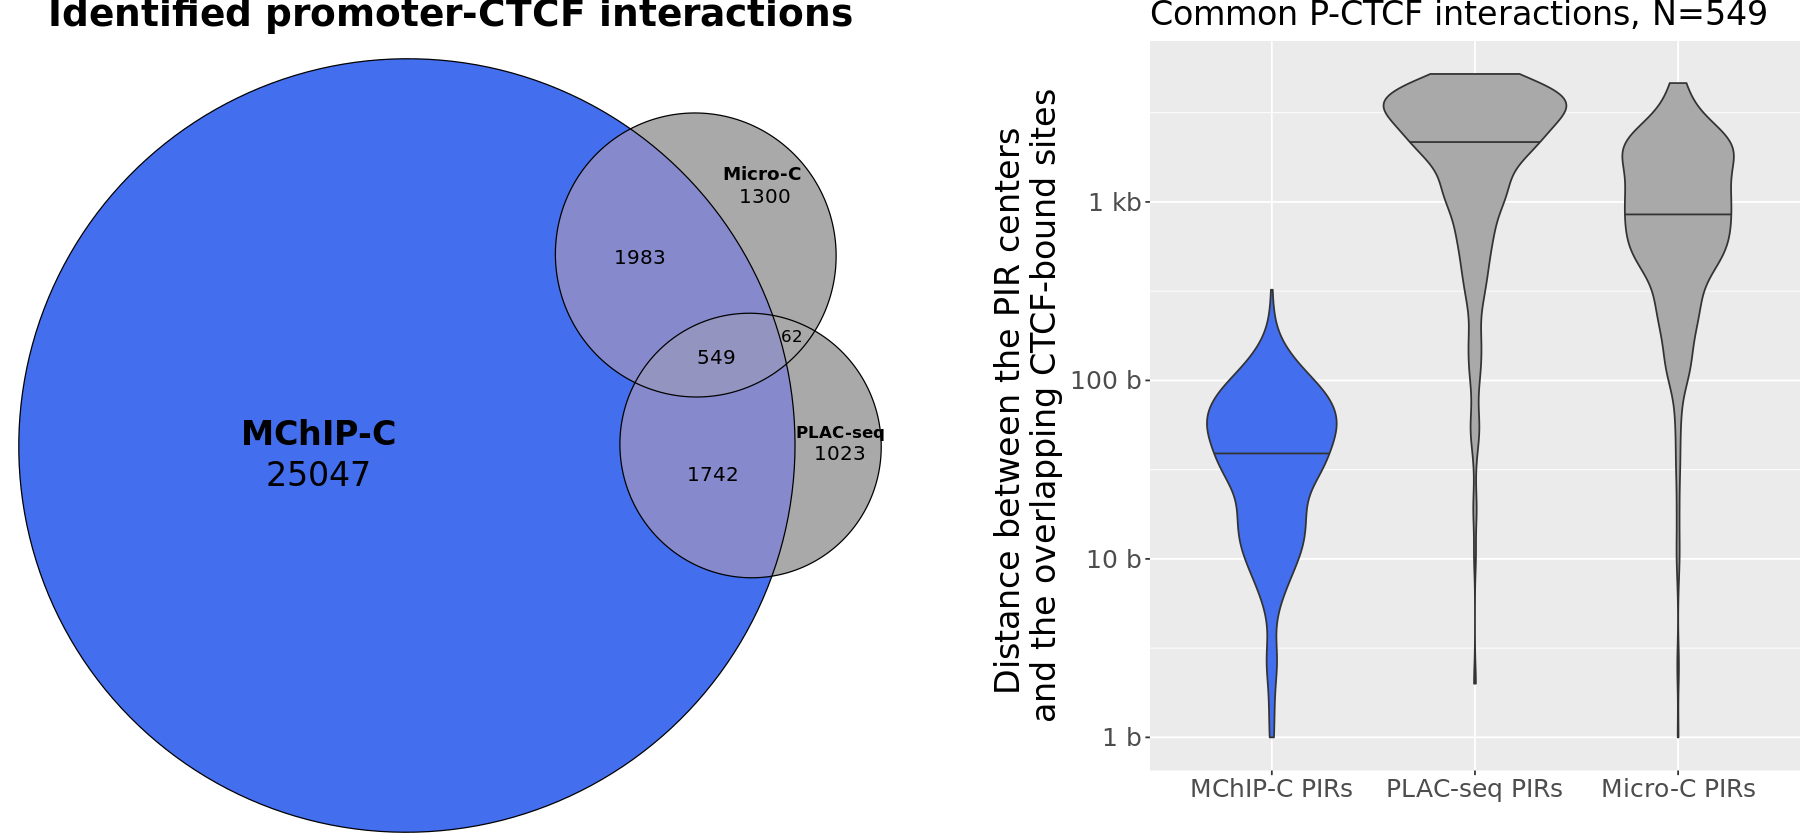

In [67]:
options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(CTCF_venn, 
             dist_CTCF_violins+theme(plot.margin=unit(c(0,0,0,2),"cm")),
             widths=c(0.5,0.5), heights=0.9, ncol=2)